# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition 

### Idea:
- get plain CDR running for Dynamics and benchmark
- check accuracy of CDR vs runtime/step division (problem is small step division, not runtime)
- add perturbation approach (all non-Cliffords) if necessary
- add noise levels (data augmentation) if necessary



In [3]:
include("src/cpa.jl")

run_method (generic function with 1 method)

# MWE
### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [18]:
nq = 9
steps = 7
T = steps/20
J =  2.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0  #abs(h) < abs(J) in ordered phase
angle_definition = pi/20
# paramagnetic (h = -2, J = 1)
#trotter = trotter_kickedising_setup(nq, steps, T, J, h);
trotter = trotter_setup(nq, steps, T, J, h);
observable= obs_interaction(trotter);
min_abs_coeff = 0.0;

In [19]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ",trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.09999999999999999 sigma_J = -0.19999999999999998    pi/20 = 0.15707963267948966

### Target data

In [20]:
exact_expval_target = trotter_time_evolution(trotter; observable = observable, record=true, min_abs_coeff=min_abs_coeff,max_weight = Inf)


8-element Vector{Float64}:
 1.0
 0.990033288920621
 0.9619393455412939
 0.9207421423813666
 0.8735947972202458
 0.8282579258283804
 0.7915051528191506
 0.7678238829541897

In [21]:
noisy_expval_target = trotter_time_evolution(trotter; observable = observable, noise_kind="gate_ising", record=true, min_abs_coeff=min_abs_coeff);

In [22]:
println(noisy_expval_target)

[1.0, 0.9510220271043257, 0.8879573890567496, 0.8172334953205904, 0.7459561445820899, 0.6804578175872463, 0.6252046032659673, 0.5822465004963526]


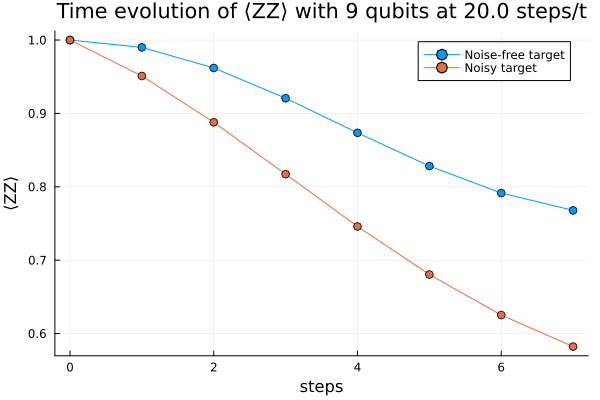

In [23]:
plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
elseif observable == obs_magnetization(trotter)
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

### Training data

In [24]:
#list_training_thetas = training_set_generation_brut(trotter, angle_definition; num_samples=10, non_replaced_gates=30);

In [25]:
#list_training_thetas = training_set_generation_strict_perturbation(trotter;sample_function = "small",num_samples=10);

In [30]:
list_training_thetas = training_set_generation_loose_perturbation(trotter;sample_function = "small",num_samples=10);

In [31]:
exact_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, record=true);

In [32]:
noisy_expvals = training_trotter_time_evolution(trotter, list_training_thetas; observable = observable, noise_kind="gate_ising", record = true);

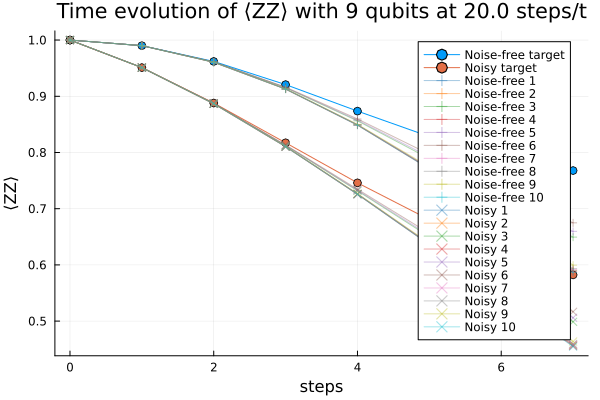

In [33]:
colors = palette(:tab10)

plot(0:trotter.steps, exact_expval_target, xlabel="steps", label="Noise-free target", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy target", marker=:o)

for (i, exact) in enumerate(exact_expvals)
    plot!(0:trotter.steps, exact, label="Noise-free $(i)", c=colors[i], marker=:+, alpha = 0.4)
end

for (i, noisy) in enumerate(noisy_expvals)
    plot!(0:trotter.steps, noisy, label="Noisy $(i)", color=colors[i], marker=:x, alpha = 0.4)
end

if observable == obs_interaction(trotter)
    plot!(ylabel="⟨ZZ⟩", title = "Time evolution of ⟨ZZ⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
else
    plot!(ylabel="⟨Z⟩",title = "Time evolution of ⟨Z⟩ with $(trotter.nqubits) qubits at $(trotter.steps/trotter.time) steps/t")
end

In [34]:
# CDR considering only last step
corrected, rel_after, rel_before = cdr(
    noisy_expvals,
    exact_expvals,
    noisy_expval_target; exact_target_exp_value = exact_expval_target, use_target=true
)

#CDR with decaying weights
decay_weights = [
    [τ == t ? 1.0 : (τ == t-1 ? 0.5 : 0.0) for τ in 1:t]
    for t in 1:length(noisy_expvals[1])
]
corrected_weight, rel_after_weight, rel_before_weight = cdr(
    noisy_expvals,
    exact_expvals,
    noisy_expval_target, decay_weights; exact_target_exp_value = exact_expval_target, use_target=true
)

([1.0, 0.9900332889206207, 0.9612179529123954, 0.9174556127545903, 0.8650010529246092, 0.8112881389056456, 0.7640846104431632, 0.7313318853457246], [0.0, 3.3641990740601414e-16, 0.0007499356713520649, 0.0035694354320268224, 0.009837220096756178, 0.020488529470771535, 0.03464354246882914, 0.047526520623535115], [0.0, 0.03940399000000007, 0.07690916982183928, 0.11241871344464158, 0.1461073864499863, 0.17844695913209901, 0.210106717512654, 0.24169264147375977])

### Correction over time (standard CDR vs. weighted linear regression)

In [35]:
plot(1:trotter.steps, rel_before[2:end-1], xlabel="steps", label="rel. error before correction", marker=:o)
plot!(1:trotter.steps, rel_after[2:end-1], label="rel. error after correction (LR)", marker=:o)
plot!(1:trotter.steps, rel_after_weight[2:end-1], label="rel. error after correction (weighted LR)", marker=:o, yscale=:log10,legend=:best)

# CDR tests

### Full Run Test

In [16]:
#now full run is set to the loose method
global_logger(UnbufferedLogger(stdout, MainInfo))

nq = 9
steps = 5
sigma_star = pi/20
T = 0.2
J = 2.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);
noise_kind = "gate_ising" #takes the default gate values
min_abs_coeff = 1e-10; #training set (exact and noisy)
min_abs_coeff_exact = 0.0 #this should be 0 to get
min_abs_coeff_noisy = min_abs_coeff;
observable  = obs_interaction(trotter) #propagate doesn't like PauliStrings for some reason

#observable = PauliString(nq, :Z, 5) #obs_interaction(trotter); #obs_magnetization(trotter);
#training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "CPA", num_samples=10);
#training_set = training_set_generation_brut(trotter, sigma_star; num_samples=10, non_replaced_gates=30);
exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind; min_abs_coeff,max_weight = 8, min_abs_coeff_noisy, observable = observable, record = true, cdr_method = "end", use_target = false, real_qc_noisy_data = 1e-3)

(NaN, 0.001, 0.02760064419670446, NaN, NaN)

### CDR weight assignment test

In [39]:
#now full run is set to the loose method
global_logger(UnbufferedLogger(stdout, MainInfo))

nq = 9
steps = 7
sigma_star = pi/20
T = 0.25
J = 2.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);
cdr_methods = ["std_LR", "lin_WLR", "last1_WLR"]
rel_after_list = Vector{Vector{Float64}}()
for cdr_method in cdr_methods
    noise_kind ="gate_ising" #takes the default gate values
    min_abs_coeff = 0.0 #1e-10; #traiing set (exact and noisy)#this should be 0 to get
    min_abs_coeff_noisy = min_abs_coeff;
    training_set = training_set_generation_loose_perturbation(trotter, sigma_star; sample_function = "small", num_samples=10);
    #training_set = training_set_generation_brut(trotter, sigma_star; num_samples=10, non_replaced_gates=30);
    #we can make this more efficient by not recalc the "exact" expvals
    exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind; min_abs_coeff, min_abs_coeff_noisy, training_set, observable = obs_magnetization(trotter),record = true, cdr_method = cdr_method)
    # add to dataframe each time (only rel_error_after, with cdr_method label)
    rel_error_after = rel_error_after[2:end] #remove the first one, as it is not corrected
    rel_after_list = push!(rel_after_list, rel_error_after)
    #then add once the rel_error_before
end

In [40]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ",trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.07142857142857142 sigma_J = -0.14285714285714285    pi/20 = 0.15707963267948966

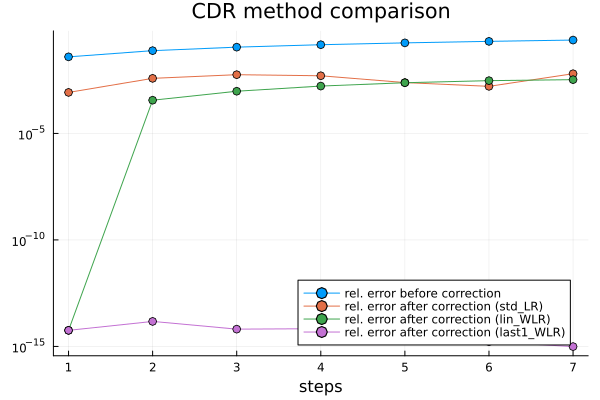

In [41]:
plot(1:trotter.steps, rel_before[2:end], xlabel="steps", label="rel. error before correction", marker=:o,title = "CDR method comparison")
plot!(1:trotter.steps, rel_after_list[1], label="rel. error after correction (std_LR)", marker=:o)
plot!(1:trotter.steps, rel_after_list[2], label="rel. error after correction (lin_WLR)", marker=:o)
plot!(1:trotter.steps, rel_after_list[3], label="rel. error after correction (last1_WLR)", marker=:o)
plot!(yscale=:log10,legend=:bottomright)